<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/CV/classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import packages
import tensorflow as tf
import os

import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cv2 import imread, createCLAHE 
import cv2

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
from keras.applications.vgg16 import VGG16

import PIL
from PIL import Image

import imutils
from glob import glob


In [3]:
img_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝/CV_Project/DATASET/Classification/'

In [4]:
train_dir = img_path+'train/'
test_dir = img_path+'test/'
model_directory = img_path + 'MODEL/'
tensorboard_directory = img_path + 'Tensorboard'

In [ ]:
#create classes
#classes = os.listdir(train_dir)
#print(classes)

In [ ]:
#files_path_dict = {}# 모든 training image 파일을 class별로 list를 만듬

#for c in classes:
#  if not c.startswith('.') :
#    files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))
#   
#  else :
#    pass

In [5]:
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]
    
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [6]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝/CV_Project/DATASET/Classification/train"

normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [7]:
#check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []

for i in os.listdir(train_dir):

  if not i.startswith('.') :
    train_class = os.listdir(os.path.join(train_dir, i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print('Number of images in {} = {} \n'.format(i, len(train_class)))

   
  else :
    pass


Number of images in Covid = 111 

Number of images in Normal = 70 

Number of images in Viral Pneumonia = 70 



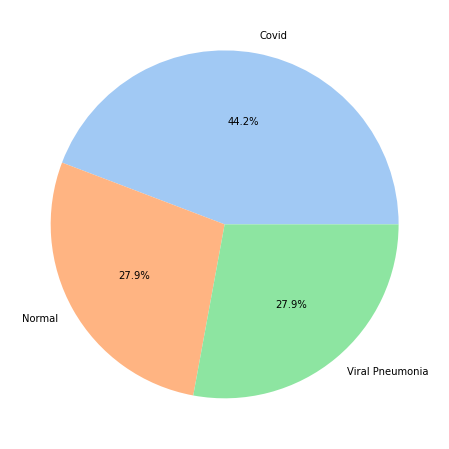

In [8]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [9]:
#visualize
import matplotlib.pyplot as plt
from ipywidgets import interact

In [10]:
# 이미지 파일을 RGB 3차원 배열로 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [11]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [12]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [13]:
img_width, img_height = 224, 224
batch_size = 32

In [14]:
# Generator의 instance 생성 (Train)

TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 226 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
Image, Label = TRAIN_GENERATOR.__getitem__(0)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:

#view the class dictionary
print(TRAIN_GENERATOR.class_indices)
print(TEST_GENERATOR.class_indices)


{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


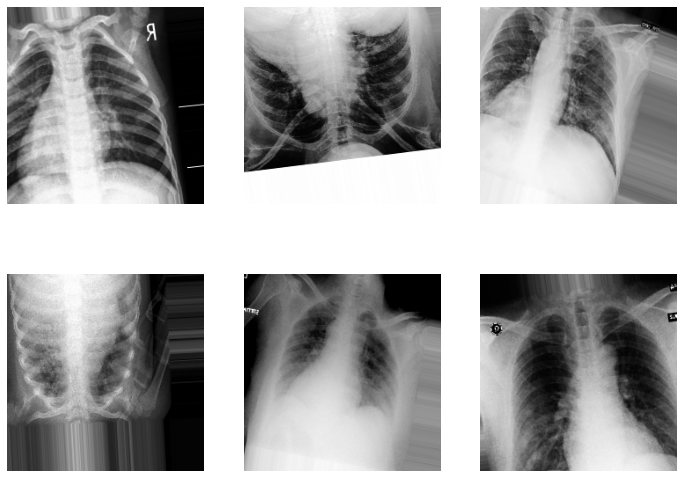

In [ ]:

#view the augmented data
sample_x, sample_y = next(TRAIN_GENERATOR)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


In [ ]:
# Pooling이 있는 모델의 경우
VGGModel = tf.keras.applications.VGG16(include_top=False,    
                                    weights='imagenet', input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(VGGModel.output)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=VGGModel.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=
         SGD(lr=0.001, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc'])

# define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
########## Training Start
history = model.fit(
                    TRAIN_GENERATOR,
        
                    epochs=30,
                    shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
                    validation_data=VALID_GENERATOR,)
###########

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
8/8 [==============================] - 17s 2s/step - loss: 1.1319 - acc: 0.3850 - val_loss: 1.0017 - val_acc: 0.4400
Epoch 2/30
8/8 [==============================] - 14s 2s/step - loss: 0.8978 - acc: 0.5442 - val_loss: 0.7944 - val_acc: 0.6000
Epoch 3/30
8/8 [==============================] - 14s 2s/step - loss: 1.1659 - acc: 0.4956 - val_loss: 1.0031 - val_acc: 0.4400
Epoch 4/30
8/8 [==============================] - 14s 2s/step - loss: 0.9470 - acc: 0.5177 - val_loss: 0.8685 - val_acc: 0.6800
Epoch 5/30
8/8 [==============================] - 15s 2s/step - loss: 0.7650 - acc: 0.6903 - val_loss: 1.4549 - val_acc: 0.4800
Epoch 6/30
8/8 [==============================] - 14s 2s/step - loss: 1.1087 - acc: 0.5885 - val_loss: 0.7693 - val_acc: 0.6800
Epoch 7/30
8/8 [==============================] - 14s 2s/step - loss: 0.7051 - acc: 0.7080 - val_loss: 0.8084 - val_acc: 0.6000
Epoch 8/30
8/8 [==============================] - 14s 2s/step - loss: 0.6365 - acc: 0.7434 - val_loss: 0

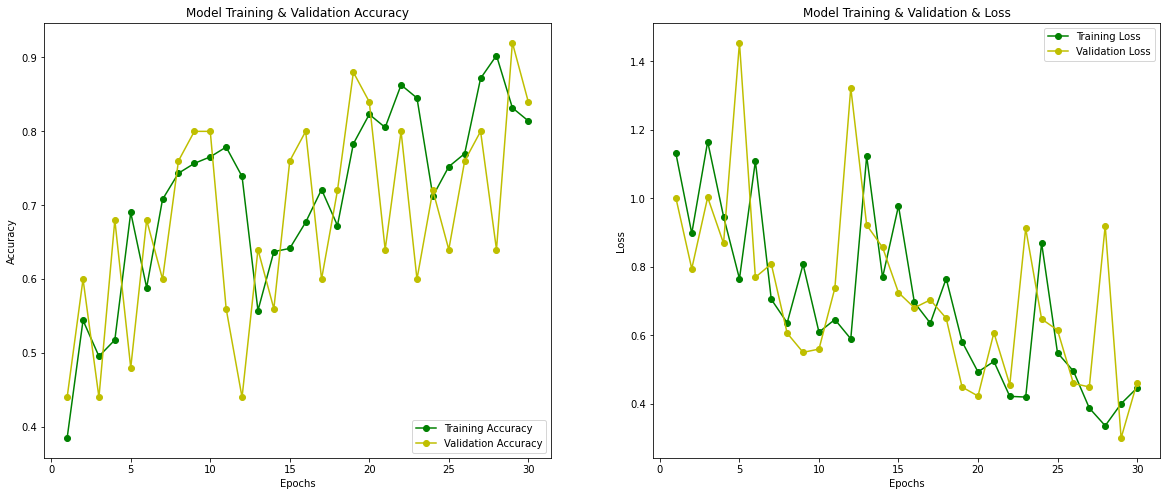

In [ ]:

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:

print('Train loss & accuracy :', model.evaluate(TRAIN_GENERATOR))
print('\n')
print('Test loss & accuracy :', model.evaluate(TEST_GENERATOR))


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


8/8 [==============================] - 11s 1s/step - loss: 0.2649 - acc: 0.9381
Train loss & accuracy : [0.2648540139198303, 0.9380530714988708]


3/3 [==============================] - 9s 4s/step - loss: 0.3398 - acc: 0.8939
Test loss & accuracy : [0.3397519588470459, 0.8939393758773804]


In [ ]:
T = int(input())
for _ in range(T):
    N = int(input())
    digits = list(map(int, input().split()))
    
print(max(digits), min(digits))

In [ ]:

#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)


[[63  2  2]
 [ 0 28  5]
 [ 0 12  6]]


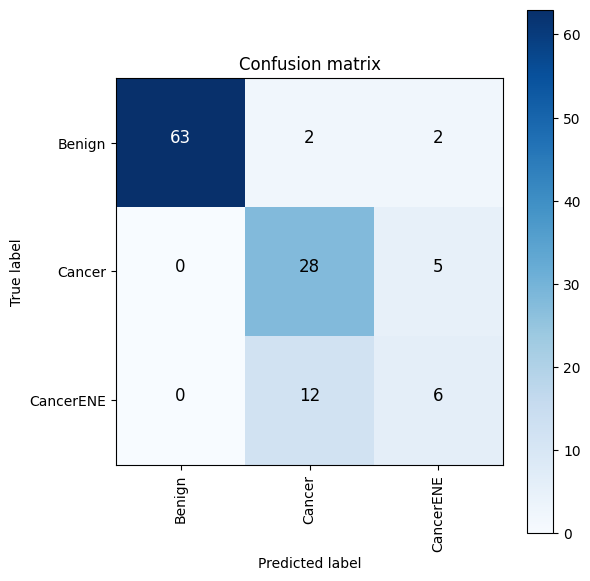

In [ ]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)


In [ ]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        67
           1       0.67      0.85      0.75        33
           2       0.46      0.33      0.39        18

    accuracy                           0.82       118
   macro avg       0.71      0.71      0.70       118
weighted avg       0.82      0.82      0.82       118



In [ ]:
reverse_dict= dict(map(reversed,test_data.class_indices.items()))

In [ ]:

#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"
    
    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    
    #predict
    prediction = model.predict(img)
    
    #prediction index
    prediction_idx = np.argmax(prediction)
    
    #STEP 2: Create new model
    #specify last convolutional layer
    # last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    
    target_layer = model.get_layer(last_conv_layer.name)
    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]
    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)
    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]
    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img))
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        print(f"Prediction = {reverse_dict[np.argmax(prediction)]}")
        # print(test_data.class_indices.keys(np.argmax(prediction)))
        
    else:
        return cvt_heatmap


Original = Benign
Prediction = Benign


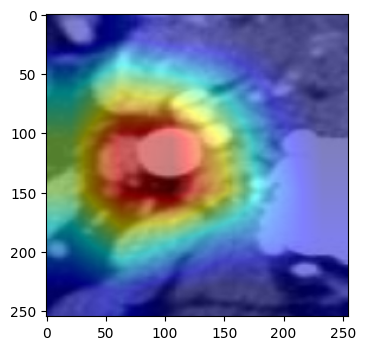

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[0] + "/8.jpg")

#apply function
print(f"Original = {classes[0]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = Cancer
Prediction = Cancer


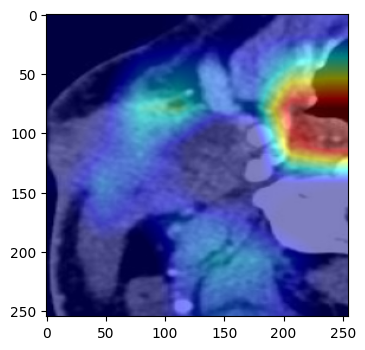

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[1] + "/17.jpg")

#apply function
print(f"Original = {classes[1]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = CancerENE
Prediction = Cancer


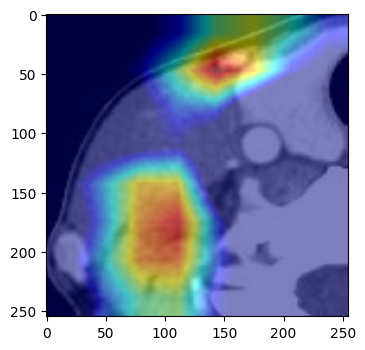

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[2] + "/5.jpg")

#apply function
print(f"Original = {classes[2]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
# import cv2
# import sys
             
# for i in os.listdir(img_path+'Test-Data/new_test'):   
#   if not i.startswith('.') :
#     # code to open the image
#     example_image = cv2.imread(os.path.join(img_path+'Test-Data/new_test', i))
#     img = cv2.resize(example_image, (240, 240))

#     #apply function
#     VizGradCAM(model, img_to_array(img), plot_results=True)
    
#     img= np.expand_dims(example_image, axis=0)
#     predict = model.predict(img)
#     predict = np.argmax(predict)
#     print(class_dict[predict])    
#   else :
#     pass
